<a href="https://colab.research.google.com/github/PRaliphada/ExpectedLoss/blob/main/Research_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.2 MB/s eta 0:00:00


In [19]:
import requests
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split

# NewsAPI key
newsapi_key = 'XXXXXXXXXXXXXXXXXXXXXX'

# Broader financial queries related to U.S. Treasury bonds
queries = ['U.S. Treasury', 'Treasury Bonds', 'Bond Market', 'Government Bonds']

# Set up VADER Sentiment Analyzer
analyzer = SentimentIntensityAnalyzer()

# Function to classify sentiment
def get_sentiment(text):
    sentiment_score = analyzer.polarity_scores(text)['compound']
    if sentiment_score >= 0.05:
        return 'Positive'
    elif sentiment_score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

# Function to get news articles with date range
def get_news(query, api_key, start_date, end_date, num_articles=100):
    url = f'https://newsapi.org/v2/everything?q={query}&from={start_date}&to={end_date}&apiKey={api_key}&language=en&pageSize={num_articles}'
    response = requests.get(url)
    data = response.json()

    if data['status'] != 'ok':
        print(f"Error fetching data for query '{query}': {data.get('message')}")
        return []

    news_data = []
    articles = data.get('articles', [])
    for article in articles:
        news_content = article['description'] if article['description'] else article['content']
        sentiment = get_sentiment(news_content)
        news_data.append([article['source']['name'], query, sentiment, news_content])

    return news_data

# Define your date range
start_date = '2024-08-11'
end_date = '2024-09-01'

# Store all news data
all_news = []

for query in queries:
    all_news.extend(get_news(query, newsapi_key, start_date, end_date))

# Check if any news was retrieved
if not all_news:
    print("No news articles were retrieved. Try broadening your queries or checking the API key.")
else:
    # Create a DataFrame
    df = pd.DataFrame(all_news, columns=['Source', 'Entity', 'Sentiment', 'News Content'])

    # Split the data into training and validation sets
    train, validation = train_test_split(df, test_size=0.2, random_state=42)

    # Save to CSV
    train.to_csv('financial_news_bonds_sentiment_train.csv', index=False)
    validation.to_csv('financial_news_bonds_sentiment_val.csv', index=False)

    # Print the first few rows of the training and validation sets
    print("Training Set:")
    print(train.head())

    print("\nValidation Set:")
    print(validation.head())


Training Set:
          Source         Entity Sentiment  \
3    MarketWatch  U.S. Treasury   Neutral   
18          Time  U.S. Treasury  Positive   
202         CNET    Bond Market   Neutral   
250       Forbes    Bond Market   Neutral   
274       Forbes    Bond Market  Positive   

                                          News Content  
3    Benchmark bond yields were a touch higher earl...  
18   A crackdown on gangs has made the authoritaria...  
202  A few notable mortgage rates climbed higher. H...  
250  Asian equities were largely higher on light vo...  
274  What happened to the US stock market is really...  

Validation Set:
                  Source         Entity Sentiment  \
209  Yahoo Entertainment    Bond Market  Positive   
280               Forbes    Bond Market  Positive   
33   Yahoo Entertainment  U.S. Treasury  Positive   
210                 CNET    Bond Market  Positive   
93                  NASA  U.S. Treasury  Positive   

                                     

In [20]:
train = train.dropna(subset=['News Content'])

display(train.isnull().sum())
print("*****"* 5)
display(validation.isnull().sum())

,0
Source,0
Entity,0
Sentiment,0
News Content,0


*************************


,0
Source,0
Entity,0
Sentiment,0
News Content,0


In [21]:
duplicates = train[train.duplicated(subset=['Entity', 'Sentiment', 'News Content'], keep=False)]
train = train.drop_duplicates(subset=['Entity', 'Sentiment', 'News Content'], keep='first')

duplicates = validation[validation.duplicated(subset=['Entity', 'Sentiment', 'News Content'], keep=False)]
validation = validation.drop_duplicates(subset=['Entity', 'Sentiment', 'News Content'], keep='first')

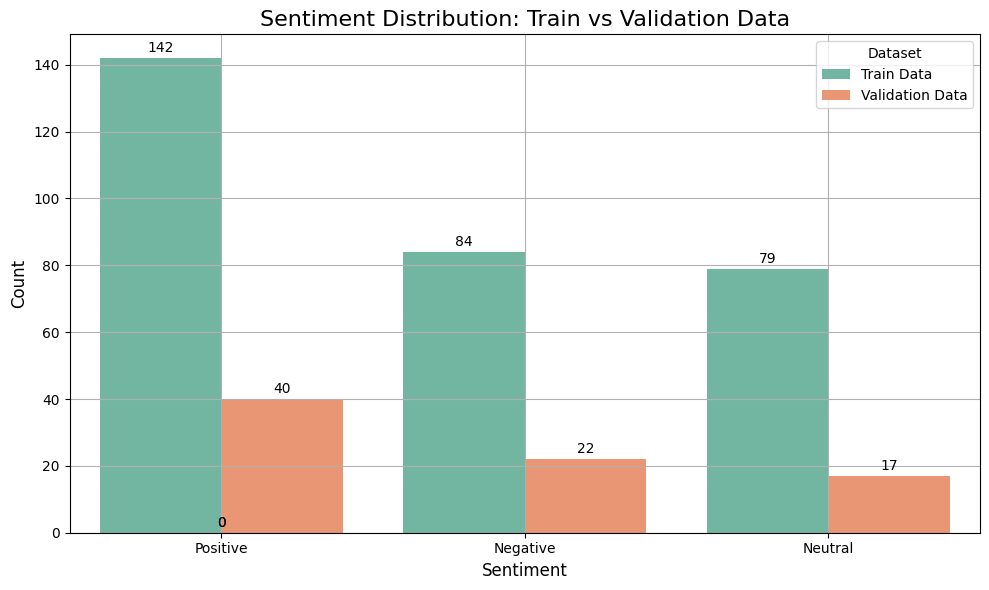

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming 'train' and 'validation' are your DataFrames

# Calculate sentiment counts for train and validation data
train_sentiment_counts = train['Sentiment'].value_counts().rename('Train Data')
validation_sentiment_counts = validation['Sentiment'].value_counts().rename('Validation Data')

# Combine counts into a DataFrame
combined_sentiment_counts = pd.DataFrame({
    'Train Data': train_sentiment_counts,
    'Validation Data': validation_sentiment_counts
})

# Fill missing values with 0
combined_sentiment_counts.fillna(0, inplace=True)

# Reset index to prepare for plotting
combined_sentiment_counts.reset_index(inplace=True)
combined_sentiment_counts.rename(columns={'index': 'Sentiment'}, inplace=True)

# Melt the DataFrame for easier plotting with seaborn
combined_sentiment_counts_melted = combined_sentiment_counts.melt(id_vars='Sentiment',
                                                                  var_name='Dataset',
                                                                  value_name='Count')

# Create the bar plot
plt.figure(figsize=(10, 6))
barplot = sns.barplot(x='Sentiment', y='Count', hue='Dataset', data=combined_sentiment_counts_melted, palette="Set2")

# Add count values on top of the bars
for p in barplot.patches:
    barplot.annotate(f'{int(p.get_height())}',
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center', xytext=(0, 7), textcoords='offset points', fontsize=10)

# Add title and labels
plt.title('Sentiment Distribution: Train vs Validation Data', fontsize=16)
plt.xlabel('Sentiment', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.grid(True)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


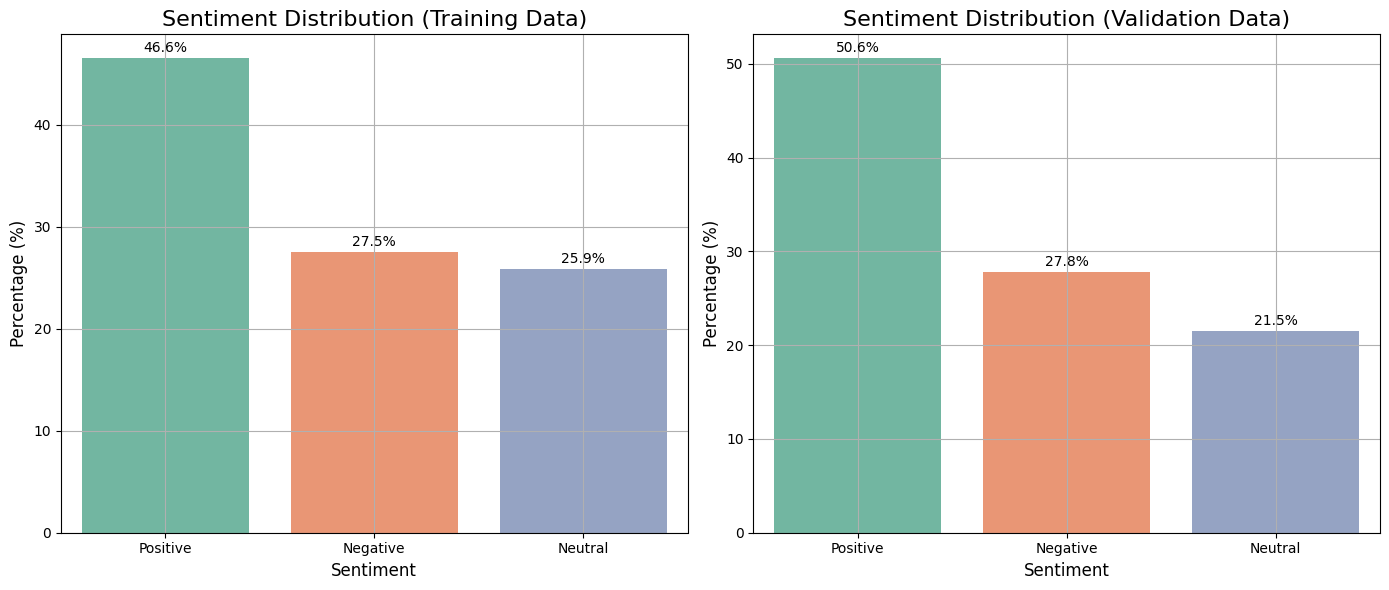

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Assuming 'train' and 'validation' are your DataFrames

# Calculate sentiment percentages for train and validation data
sentiment_counts_train = train['Sentiment'].value_counts(normalize=True) * 100
sentiment_counts_validation = validation['Sentiment'].value_counts(normalize=True) * 100

# Create a figure and axes for subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))  # Adjusting the figure size

# Plot training data sentiment distribution
barplot_train = sns.barplot(x=sentiment_counts_train.index, y=sentiment_counts_train.values, ax=ax1, palette="Set2")
ax1.set_title('Sentiment Distribution (Training Data)', fontsize=16)
ax1.set_ylabel('Percentage (%)', fontsize=12)
ax1.set_xlabel('Sentiment', fontsize=12)
ax1.grid(True)

# Add percentage labels on top of bars for training data
for p in barplot_train.patches:
    barplot_train.annotate(f'{p.get_height():.1f}%',
                           (p.get_x() + p.get_width() / 2., p.get_height()),
                           ha='center', va='center', xytext=(0, 7), textcoords='offset points', fontsize=10)

# Plot validation data sentiment distribution
barplot_validation = sns.barplot(x=sentiment_counts_validation.index, y=sentiment_counts_validation.values, ax=ax2, palette="Set2")
ax2.set_title('Sentiment Distribution (Validation Data)', fontsize=16)
ax2.set_ylabel('Percentage (%)', fontsize=12)
ax2.set_xlabel('Sentiment', fontsize=12)
ax2.grid(True)

# Add percentage labels on top of bars for validation data
for p in barplot_validation.patches:
    barplot_validation.annotate(f'{p.get_height():.1f}%',
                                (p.get_x() + p.get_width() / 2., p.get_height()),
                                ha='center', va='center', xytext=(0, 7), textcoords='offset points', fontsize=10)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


In [31]:
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical

import pandas as pd
from sklearn.model_selection import train_test_split

In [39]:
import pandas as pd
import plotly.graph_objects as go

# Assuming 'train' is your DataFrame

# Sample 5 random rows
data_sample = data.sample(n=5, random_state=1)  # Set random_state for reproducibility

# Define colors for sentiment categories
color_map = {
    'Positive': 'green',
    'Neutral': 'orange',
    'Negative': 'red'
}

# Create a colorful table using Plotly
fig = go.Figure(data=[go.Table(
    header=dict(
        values=list(data_sample.columns),
        fill_color='paleturquoise',
        align='left',
        font=dict(color='black', size=12)
    ),
    cells=dict(
        values=[data_sample[k].tolist() for k in data_sample.columns],
        fill_color=[
            'lightcyan',  # News Content
            [color_map[s] for s in data_sample['Sentiment_label']],  # Sentiment_label # Use Sentiment_label to access the color map
            [color_map[s] for s in data_sample['Sentiment_label']],  # Sentiment_label
            'lavender'  # Sentiment (numeric)
        ],
        align='left',
        font=dict(color='black', size=11)
    ))
])

# Update the layout
fig.update_layout(
    title='Random 5 Rows of Training Data',
    width=1000,
    height=650,
)

fig.show()

In [38]:
import plotly.graph_objects as go

# Sample 5 random rows from the test data
data_test_sample = data_test.sample(n=5, random_state=1)  # Set random_state for reproducibility

# Define colors for sentiment categories
color_map = {
    'Positive': 'green',
    'Neutral': 'orange',
    'Negative': 'red'
}

# Create a colorful table using Plotly for the sampled data
fig = go.Figure(data=[go.Table(
    header=dict(
        values=list(data_test_sample.columns),
        fill_color='paleturquoise',
        align='left',
        font=dict(color='black', size=12)
    ),
    cells=dict(
        values=[data_test_sample[k].tolist() for k in data_test_sample.columns],  # Show the sampled rows
        fill_color=[
            'lightcyan',  # News Content
            [color_map.get(s, 'lightgray') for s in data_test_sample['Sentiment']],  # Sentiment
            [color_map.get(s, 'lightgray') for s in data_test_sample['Sentiment_label']],  # Sentiment_label
            'lavender'  # Sentiment (numeric)
        ],
        align='left',
        font=dict(color='black', size=11)
    ))
])

# Update the layout
fig.update_layout(
    title='Random 5 Rows of Test Data',
    width=1000,
    height=600,
)

# Show the figure
fig.show()

# If you want to save the figure as an HTML file, uncomment the following line:
# fig.write_html("test_data_sample.html")


In [41]:
%%time
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.metrics import accuracy_score

# Preprocess the data
def preprocess_data(df):
    df['label'] = df['Sentiment_label'].map({'Positive': 2, 'Negative': 0, 'Neutral': 1})
    return df['News Content'].tolist(), df['label'].tolist()

train_texts, train_labels = preprocess_data(data_train)
test_texts, test_labels = preprocess_data(data_test)

# Define the custom dataset
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Initialize tokenizer and datasets
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_dataset = SentimentDataset(train_texts, train_labels, tokenizer)
test_dataset = SentimentDataset(test_texts, test_labels, tokenizer)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Initialize the model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Set up optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

# Training loop
num_epochs = 3
for epoch in range(num_epochs):
    model.train()
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

    # Evaluation on test set
    model.eval()
    test_preds = []
    test_true = []
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
            test_preds.extend(preds)
            test_true.extend(labels.cpu().numpy())

    accuracy = accuracy_score(test_true, test_preds)
    print(f'Epoch {epoch + 1}/{num_epochs}, Test Accuracy: {accuracy:.4f}')

# Save the model
torch.save(model.state_dict(), 'sentiment_model_BERT.pth')


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3, Test Accuracy: 0.5063
Epoch 2/3, Test Accuracy: 0.5570
Epoch 3/3, Test Accuracy: 0.5696


In [42]:
# Final evaluation

print(classification_report(test_true, test_preds, target_names=['Negative', 'Neutral', 'Positive']))

              precision    recall  f1-score   support

    Negative       0.75      0.14      0.23        22
     Neutral       0.67      0.24      0.35        17
    Positive       0.55      0.95      0.70        40

    accuracy                           0.57        79
   macro avg       0.66      0.44      0.43        79
weighted avg       0.63      0.57      0.49        79



In [43]:
# Assuming test_true and test_preds are defined
from sklearn.metrics import confusion_matrix

# Check if test_true labels need conversion (optional)
if not isinstance(test_true[0], str):  # If labels are not strings
    from sklearn.preprocessing import LabelEncoder
    encoder = LabelEncoder()
    test_true_encoded = encoder.fit_transform(test_true)  # Encode labels
    labels = [0, 1, 2]  # Numerical labels
else:
    test_true_encoded = test_true
    labels = ['Negative', 'Neutral', 'Positive']  # String labels

# Calculate confusion matrix with consistent labels
confusion_matrix_BERT = confusion_matrix(test_true_encoded, test_preds, labels=labels)

print("Confusion matrix BERT \n")
confusion_matrix_BERT

Confusion matrix BERT 



array([[ 3,  0, 19],
       [ 1,  4, 12],
       [ 0,  2, 38]])

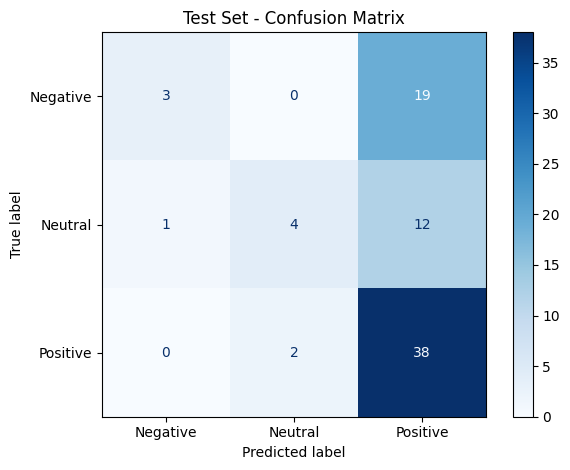

In [44]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
labels = ['Negative', 'Neutral', 'Positive']  # String labels
test_display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_BERT, display_labels=labels)
test_display.plot(cmap='Blues')
plt.title("Test Set - Confusion Matrix")
plt.grid(False)
plt.tight_layout()
plt.show()

In [56]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


In [57]:
# Assuming `df` is your DataFrame with columns ['Source', 'Entity', 'Sentiment', 'News Content']

# Handle NaN values by dropping rows with missing 'Sentiment' or 'News Content'
df = df.dropna(subset=['Sentiment', 'News Content'])

# Convert 'Sentiment' to numeric labels (Negative: 0, Neutral: 1, Positive: 2)
df['Sentiment'] = df['Sentiment'].map({'Negative': 0, 'Neutral': 1, 'Positive': 2})

# Ensure that there are no empty strings or very short texts in 'News Content'
df = df[df['News Content'].str.strip().astype(bool)]  # Remove empty strings
df = df[df['News Content'].str.len() > 10]  # Remove very short texts that are too small to analyze

# Split into features (X) and target (y)
X = df['News Content']
y = df['Sentiment']


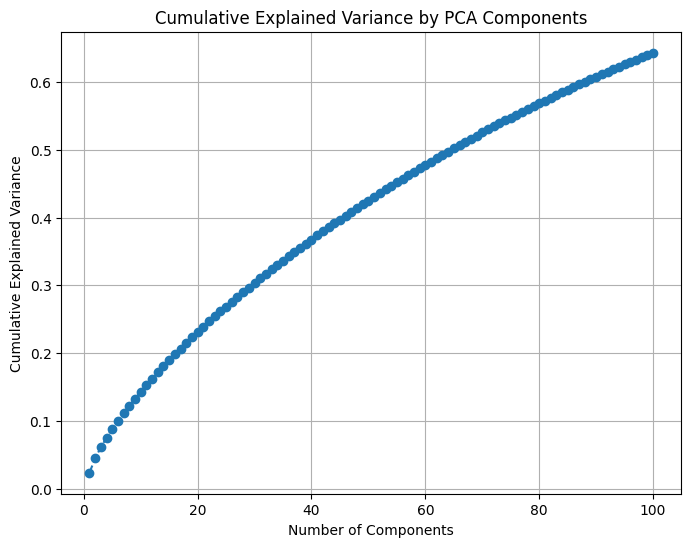

In [50]:
# Apply PCA for dimensionality reduction
pca = PCA(n_components=100)  # Adjust n_components as needed
X_pca = pca.fit_transform(X_tfidf)

# Plot 1: Explained Variance Plot
explained_variance = pca.explained_variance_ratio_
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance)+1), explained_variance.cumsum(), marker='o', linestyle='--')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()
